In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
#import import_ipynb
import utils_GTDmodel
from joblib import dump, load
import imp
imp.reload(utils_GTDmodel)
#from imblearn.combine import SMOTEENN

<module 'utils_GTDmodel' from 'utils_GTDmodel.py'>

In [39]:
#DEFINE MAIN VARIABLES
filename = 'gtd_70to94_0617dist.xlsx'
var_name = '_70to94_03'
filename_data = 'data'+var_name+'.npz'
filename_one_hot = 'enc'+var_name+'.npz'
#set weight to 'noWeight', 'balanced', 'computedWeight', 'resampling'
weight = 'computedWeight'
weight_type = '_'+weight
filename_tuning = 'tuning_cv'+weight_type+var_name+'.npz'
model_type = 'modelSVC_rbf'
C_best_type = '_C'
gamma_best_type = 'g'
features_dataset = ['iyear','imonth','iday','extended','crit1','crit2','crit3','doubtterr','country','region','attacktype1','success','weaptype1','targtype1']
features_class = ['gname']
n_folds = 5
scoring = ['precision_weighted', 'recall_weighted', 'f1_weighted', 'precision_micro', 'recall_micro', 'f1_micro']
Cs = [1, 10, 100, 1000]
gammas = [0.001, 0.0001]

In [3]:
#LOADING AND SAVE DATASET AND TARGET SET ON FILE
file_data = Path(filename_data)
if not file_data.is_file():
    saved_data_labels = utils_GTDmodel.dataset_creation(filename, filename_data, features_dataset, features_class)

#LOADING DATASET AND TARGTET SET FROM COMPRESSED DATA FILE
data = np.load(filename_data)
dataset = data[data.files[1]]
#dataset.shape (58099,14)
target = data[data.files[0]]
#target.shape (58099, 1)

In [4]:
#SPLITTING DATASET INTO DATASET FOR TRAINING AND DATASET FOR PREDICTION

#DATASET FOR PREDICTION: predict_data
predict_data_index = np.where(target=="Unknown")[0]
#predict_data_index.shape -> (18154,)
predict_data = dataset[predict_data_index,:]
#predict_data.shape -> (18154, 14)

In [5]:
#DATASET FOR TRAINING: X_dataset
X_dataset = np.delete(dataset, predict_data_index, 0)
#X_dataset.shape -> (39945, 14)
Y_target = np.delete(target, predict_data_index, 0)
#Y_target.shape -> (39945, 1)

In [6]:
#1.PREPROCESSING FEATURES: DELETE EXAMPLE WITH LESS THAN n_folds+2 EXAMPLES PER CLASS
info_y_target, count_y_target = np.unique(Y_target, return_counts=True)
#info_y_target.shape -> (1978, 1)
#1978 classes in the original dataset

for i in range(0, info_y_target.shape[0]):
    if count_y_target[i] < (n_folds+2):
        lessData_index = np.where(Y_target == info_y_target[i])[0]
        X_dataset = np.delete(X_dataset, lessData_index, 0)
        Y_target = np.delete(Y_target, lessData_index, 0)
#X_dataset.shape-> (37119, 14)
#Y_target.shape-> (37119, 1)

new info label distribution:
list sorted occurence labels
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 28, 28, 28, 29, 29, 30, 30, 30, 31, 31, 31, 32, 33, 34, 34, 34, 34, 3

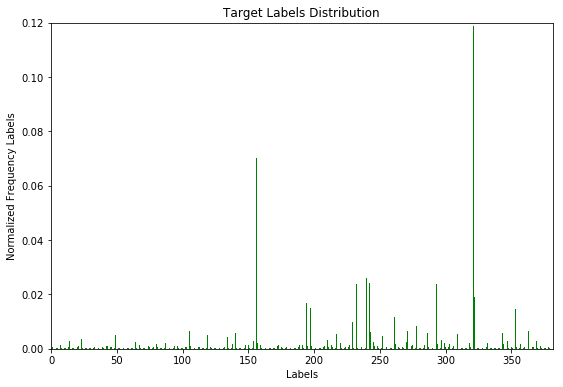

In [64]:
#NEW INFO ABOUT THE LABELS DISTRUBUTION
w_labels = []
new_info_y_target, new_count_y_target = np.unique(Y_target, return_counts=True)
tot_labels = new_info_y_target.shape[0]
#tot_labels = 381
tot_data = Y_target.shape[0]
#tot_data = 37119
utils_GTDmodel.print_plot_distribution(new_info_y_target, new_count_y_target, X_dataset.shape[0])


In [8]:
#2.PREPROCESSING FEATURES: FEATURES NORMALIZATION
X_norm_dataset = utils_GTDmodel.normalize_features(X_dataset)
#X_norm_dataset.shape-> (37119, 14)

feature 0
max: 1994
min: 1970
num_values: 24
[ 0  0  0 ..., 23 23 23]
[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1994]


feature 1
max: 12
min: 0
num_values: 13
[ 0  1  1 ..., 12 12 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


feature 2
max: 31
min: 0
num_values: 32
[ 0  1  2 ..., 31 31 31]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


feature 3
max: 1
min: 0
num_values: 2
[0 0 0 ..., 0 0 0]
[0 1]


feature 4
max: 1
min: 0
num_values: 2
[1 1 1 ..., 1 1 1]
[0 1]


feature 5
max: 1
min: 0
num_values: 2
[1 1 1 ..., 1 1 1]
[0 1]


feature 6
max: 1
min: 0
num_values: 2
[1 1 1 ..., 1 1 1]
[0 1]


feature 7
max: 1
min: -9
num_values: 3
[1 1 1 ..., 1 0 1]
[-9  0  1]


feature 8
max: 605
min: 4
num_values: 133
[ 69 116 117 ..., 113  76 116]
[  4   6   7   8  11  12  14  15  16  18  19  20  21  26  28  29  30  32
  34  36  37  38  43  44  45  49  50  51  53  55  57  

In [9]:
#3. PREPROCESSING FEATURES: ONE HOT ENCODING USING X_norm_dataset
X_set = utils_GTDmodel.one_hot_encoding(filename_one_hot, X_norm_dataset)
print('encoding done')
print(X_set.shape)
print(list(X_set[0:1].toarray()))

#X_set.shape-> (37119, 268)

[ 24  13  32   2   2   2   2   3 133  12   9   2  10  22]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

In [40]:
#WEIGHT LABEL COMPUTATION WITH THRESHOLD
if weight=='computedWeight':
    delta_threshold = 0.0001
    for i in range(len(new_count_y_target)):
        p_i_threshold = new_count_y_target[i]/np.float(tot_data)
        #print 'iter: '+str(i)+' p_i_threshold: '+str(p_i_threshold)
        #new_array = np.array([utils.func_threshold((num_dati_curr_label/np.float(tot_data)), p_i_threshold, delta_threshold) for num_dati_curr_label in new_count_y_target])
        #print list(new_array)
        num_p_i = np.sum(np.array([utils_GTDmodel.func_threshold((num_dati_curr_label/np.float(tot_data)), p_i_threshold, delta_threshold) for num_dati_curr_label in new_count_y_target]))
        w_labels.append(num_p_i / np.float(tot_labels))
    print(w_labels)
    print(new_count_y_target)
    class_weight = dict( (new_info_y_target[l], w_labels[l]) for l in range(len(new_info_y_target)) )
    print(class_weight)
else:
    print('skip weight label computation because weight is equal to '+weight)

[0.37795275590551181, 0.09711286089238845, 0.17585301837270342, 0.034120734908136482, 0.17060367454068243, 0.16010498687664043, 0.12598425196850394, 0.036745406824146981, 0.30446194225721784, 0.023622047244094488, 0.33333333333333331, 0.30446194225721784, 0.0026246719160104987, 0.062992125984251968, 0.007874015748031496, 0.34120734908136485, 0.30446194225721784, 0.33333333333333331, 0.076115485564304461, 0.09711286089238845, 0.13910761154855644, 0.03937007874015748, 0.30446194225721784, 0.0052493438320209973, 0.30446194225721784, 0.30446194225721784, 0.1994750656167979, 0.33333333333333331, 0.30446194225721784, 0.37795275590551181, 0.30446194225721784, 0.1994750656167979, 0.33333333333333331, 0.12860892388451445, 0.044619422572178477, 0.37795275590551181, 0.33333333333333331, 0.11286089238845144, 0.14960629921259844, 0.13910761154855644, 0.30446194225721784, 0.1994750656167979, 0.026246719160104987, 0.041994750656167978, 0.1994750656167979, 0.03937007874015748, 0.03937007874015748, 0.1

In [41]:
#RE-BALANCED DATSET USING IMBALANCED-LEARN
if weight=='resampling':
    X_resampled, y_resampled = utils_GTDmodel.imbalanced_resampling(X_set, Y_target)
    X_set = X_resampled
    Y_target = X_resampled
else:
    print('skip imbalanced dataset resampling because weight is equal to '+weight)
#print('plotting sparse matrix dataset')
#plt.figure(figsize=(14,12))
#plt.spy(X_set, aspect='auto')


skip imbalanced dataset resampling because weight is equal to computedWeight


In [42]:
#TUNING HYPERPARAMETERS MODEL 

#X_train, X_test, y_train, y_test = train_test_split(X_set, Y_target, test_size=0.20)
Y_arr_target = [elem[0] for elem in Y_target]
X_train, X_test, y_train, y_test = train_test_split(X_set, Y_arr_target, test_size=0.20)
#X_train.shape -> (29695, 268)
#y_train.shape -> (29695L, 1L)
#X_test.shape -> (7424, 268)
#y_test.shape -> (7424L, 1L)

#BEST PARAMETERS
#class_weight='noWeight': C = 1000; gamma = 0.001
#class_weight='balanced': C = 1000; gamma = 0.001; best_f1 = 0.69223775  
#class_weight='computedWeight': C=1000; gamma=0.001; best_f1 = 0.60272773
file_tuning = Path(filename_tuning)
if not file_tuning.is_file():
    if weight == 'computedWeight':
        grid_search_res = utils_GTDmodel.svc_param_selection(filename_tuning, Cs, gammas, class_weight, n_folds, X_train, y_train)
    else:
        grid_search_res = utils_GTDmodel.svc_param_selection(filename_tuning, Cs, gammas, weight, n_folds, X_train, y_train)
  
    
#PARAMETERS LOADING
tuning_results = np.load(filename_tuning)
f1_scores = tuning_results[tuning_results.files[0]]
C = np.float(tuning_results[tuning_results.files[1]])
gamma = np.float(tuning_results[tuning_results.files[2]])

start parameters tuning
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed: 38.0min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 74.5min
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed: 116.2min
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 182.7min
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 244.4min
[Parallel(n_jobs=5)]: Done  36 out of  40 | elapsed: 280.1min remaining: 31.1min
[Parallel(n_jobs=5)]: Done  40 out of  40 | elapsed: 287.1min finished


Best parameters for RBF kernel with BALANCED weight classes:
{'C': 1000, 'gamma': 0.001}


In [49]:
#LEARNING MODEL
filename_model = model_type+C_best_type+str(int(C))+gamma_best_type+str(gamma)+weight_type+var_name+'.pkl'
file_model = Path(filename_model)
if not file_model.is_file():
    if weight == 'noWeight':
        clf = SVC(kernel='rbf', C=C, gamma=gamma, verbose=10, decision_function_shape='ovr', random_state=42)
    if weight == 'balanced':
        clf = SVC(kernel='rbf', C=C, gamma=gamma, class_weight=weight, verbose=10, decision_function_shape='ovr', random_state=42)
    if weight == 'computedWeight':
        clf = SVC(kernel='rbf', C=C, gamma=gamma, class_weight=class_weight, verbose=10, decision_function_shape='ovr', random_state=42)
    clf.fit(X_train, y_train)
    #SAVE model
    dump(clf, filename_model)
else:
    clf = load(filename_model)

[LibSVM]

In [50]:
#TESTING MODEL
y_predicted = clf.predict(X_test)

#SCORES COMPUTATION
f1_micro = f1_score(y_test, y_predicted, average='micro')
recall_micro = recall_score(y_test, y_predicted, average='micro')
precision_micro = precision_score(y_test, y_predicted, average='micro')
# precision, recall, f1 and support for each label
labels_target = np.unique(Y_target)
scores_per_labels = precision_recall_fscore_support(y_test, y_predicted, average=None, labels=labels_target)

In [52]:
# SAVE SCORES INFO ON FILE
filename_test_scores = 'scores_'+model_type+C_best_type+str(int(C))+gamma_best_type+str(gamma)+weight_type+var_name+'.npz'
np.savez_compressed(filename_test_scores, f1_micro=f1_micro, precision_micro=precision_micro, recall_micro=recall_micro, labels_unique=labels_target, precision_labels=scores_per_labels[0], recall_labels=scores_per_labels[1], f1_labels=scores_per_labels[2], support_labels=scores_per_labels[3])
#scores_tot = np.load(filename_test_scores)
#scores_tot.files
##['recall_labels', 'f1_labels', 'support_labels', 'precision_labels', 'precision_micro', 'labels_unique', 'recall_micro', 'f1_micro']
#sl = scores_tot['support_labels']

In [51]:
y_predicted

array([u'Front for the Liberation of the Enclave of Cabinda (FLEC)',
       u'Basque Fatherland and Freedom (ETA)',
       u'African National Congress (South Africa)', ...,
       u'Shining Path (SL)', u'Red Flag (Venezuela)', u'Kach'], 
      dtype='<U77')

In [53]:
scores_tot = np.load(filename_test_scores)
#scores_tot.files
##['recall_labels', 'f1_labels', 'support_labels', 'precision_labels', 'precision_micro', 'labels_unique', 'recall_micro', 'f1_micro']
#sl = scores_tot['support_labels']